# EB Data Eval

This shows how to use backwards trajectories computed through TrajectoryNet in the gene space.

`backward_trajectories.npy` can be computed with `eval.py` generally with the same arguments as used in `main.py`. `eval.py` takes a trained TrajectoryNet model and computes backward trajectories.

These trajectories take points in the final timepoint and integrate them backwards in 100 evenly spaced timepoints to the starting timepoint. This means we now a have data that represents the inferred "paths" taken through the embedding space to the output. The case where we have an invertible embedding such as PCA, this allows us to get approximate trajectories in gene space.

In this case we performed TrajectoryNet on 5d PCA on the EB data. We then can compute the trajectories in Gene space.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scprep
import pandas as pd

In [2]:
%run ../TrajectoryNet/dataset.py

In [3]:
ds = EBData('pcs', max_dim=5)

In [4]:
ds.get_data().shape

(16819, 5)

In [5]:
zs = np.load('../results/auto3/EB-PCA/no_noise_5d/3/0/0.00e+00/1.00e-01/backward_trajectories.npy')

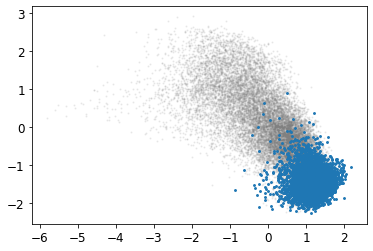

In [6]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(ds.get_data(), c='Gray', alpha=0.1, ax=ax)
scprep.plot.scatter2d(zs[-1], ax=ax)

In [7]:
zs.shape

(100, 3332, 5)

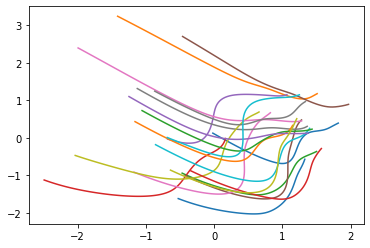

In [8]:
for i in range(20):
    plt.plot(zs[:,i,0], zs[:,i,4])

In [9]:
# Project back to the gene space.
ds.__dict__

{'val_labels': [],
 'embedding_name': 'pcs',
 'use_velocity': True,
 'data_dict': <numpy.lib.npyio.NpzFile at 0x7f2aa3a350a0>,
 'labels': array([0, 0, 0, ..., 4, 4, 4]),
 'ncells': 16819,
 'data': array([[ 0.77143535, -1.33159105, -0.1929904 , -0.29897774, -0.48215682],
        [ 1.37217473, -1.69818121, -1.19734411,  0.79338868,  1.12950888],
        [ 0.91023026, -2.06973973, -1.53785143,  1.22556852,  0.50597001],
        ...,
        [-1.75670181,  1.95747877,  0.97794163, -0.49536713,  0.75802255],
        [-2.22328289,  1.91524659,  1.71864254, -0.34609302,  0.73881308],
        [-1.08678528,  0.83653022,  1.06836545,  0.3926804 , -1.3409358 ]]),
 'velocity': array([[-0.00285746, -0.00606567, -0.0153662 ,  0.00032206,  0.00247318],
        [-0.00192217,  0.00131862,  0.00761907,  0.00276079,  0.00187319],
        [-0.00393493,  0.00194918, -0.00826185,  0.005532  ,  0.00404557],
        ...,
        [-0.03309385,  0.02425307,  0.01272812, -0.00868074,  0.03279308],
        [ 0.00

In [10]:
EBT_counts = pd.read_pickle('/home/atong/data/preprocessed_ebt_counts.pkl')
sample_labels = pd.read_pickle('/home/atong/data/preprocessed_ebt_counts_labels.pkl')

In [11]:
import phate
phate_operator = phate.PHATE(n_jobs=-2, random_state=42)
Y_phate = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 cells and 17845 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 42.75 seconds.
    Calculating KNN search...
    Calculated KNN search in 13.76 seconds.
    Calculating affinities...
    Calculated affinities in 0.31 seconds.
  Calculated graph and diffusion operator in 59.90 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.97 seconds.
    Calculating KMeans...
    Calculated KMeans in 20.68 seconds.
  Calculated landmark operator in 24.33 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.66 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.89 seconds.
Calculated PHATE in 97.52 seconds.


In [12]:
import sklearn.preprocessing
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(phate_operator.graph.data_nu)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
zss = zs * scaler.scale_[:5] + scaler.mean_[:5]

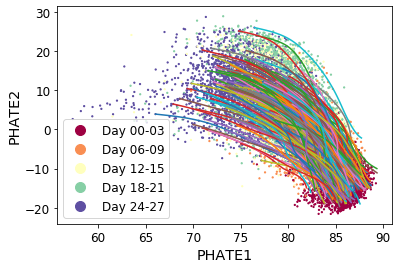

In [14]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(phate_operator.graph.data_nu, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=True, label_prefix="PHATE", ax=ax)

for i in range(200):
    ax.plot(zss[:,i,0], zss[:,i,1])

In [15]:
zss.shape, 

((100, 3332, 5),)

In [16]:
pcs = phate_operator.graph.data_pca.components_[:5]

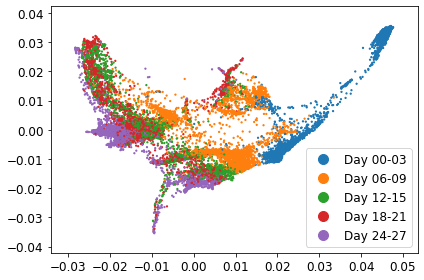

In [17]:
scprep.plot.scatter2d(Y_phate, sample_labels)

In [25]:
end_genes = ['PDGFRA ', 'HAND1', 'SOX17', 'ONECUT2', ]
end_points = ['Muscle', 'Cardiac', 'Endothelial', 'Neuronal',]
#end_genes = [ 'HAND1', 'ONECUT2',]
#end_points = ['Cardiac', 'Neuronal', ]

colors = dict(zip(*[end_genes, [plt.get_cmap('tab10')(i+1) for i in range(len(end_genes))]]))
print(colors)
other_genes = ['GATA6 ', 'SATB1', 'T ', 'EOMES', 'NANOG', 'TNNT2', 'DLX1', 'TBX18', 'MAP2 ']
genes_of_interest = [*other_genes, *end_genes]
genes_of_interest_end = scprep.select.get_gene_set(EBT_counts, starts_with=end_genes)
genes_of_interest_other = scprep.select.get_gene_set(EBT_counts, starts_with=other_genes)
genes_of_interest_full = scprep.select.get_gene_set(EBT_counts, starts_with=genes_of_interest)
print(genes_of_interest_full.shape)
genes_mask = EBT_counts.columns.isin(genes_of_interest_full)

genes = EBT_counts.columns[genes_mask]

inverse = np.dot(zss, phate_operator.graph.data_pca.components_[:5, genes_mask])
end_gene_indexes = [(np.where(genes_of_interest_full == gene)[0][0]) for gene in genes_of_interest_end]


{'PDGFRA ': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'HAND1': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'SOX17': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'ONECUT2': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)}
(13,)


In [26]:
zss.shape, phate_operator.graph.data_pca.components_[:5, genes_mask].shape

((100, 3332, 5), (5, 13))

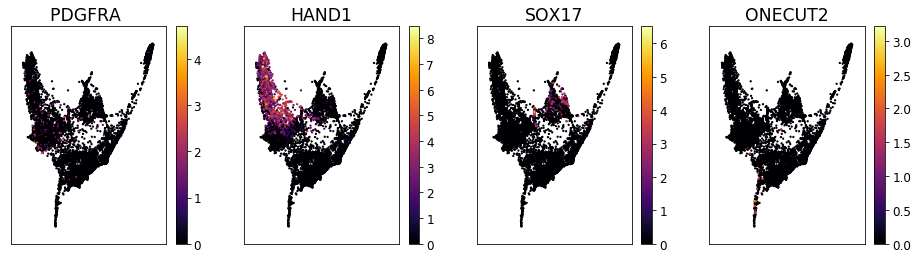

In [27]:
fig, ax = plt.subplots(1,len(end_genes), figsize=(4*len(end_genes),4))
ax = ax.flatten()
for i in range(len(end_genes)):
    scprep.plot.scatter2d(Y_phate, 
                          c=EBT_counts[scprep.select.get_gene_set(EBT_counts, starts_with=end_genes[i])], 
                          ax=ax[i],
                          title=end_genes[i],
                          ticks=[],
                         )

In [28]:
import magic

m_op = magic.MAGIC()
m_op.graph = phate_operator.graph
X_magic = m_op.transform(EBT_counts, genes=genes_of_interest_full)

/home/atong/.local/lib/python3.8/site-packages/magic/magic.py:589: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculating imputation...
Calculated imputation in 0.03 seconds.


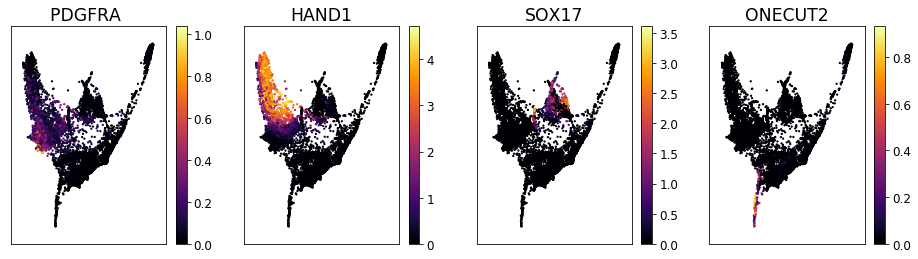

In [29]:
fig, ax = plt.subplots(1,len(end_genes), figsize=(4*len(end_genes),4))
ax = ax.flatten()
for i in range(len(end_genes)):
    scprep.plot.scatter2d(Y_phate, 
                          c=X_magic[scprep.select.get_gene_set(EBT_counts, starts_with=end_genes[i])], 
                          ax=ax[i],
                          title=end_genes[i],
                          ticks=[],
                         )

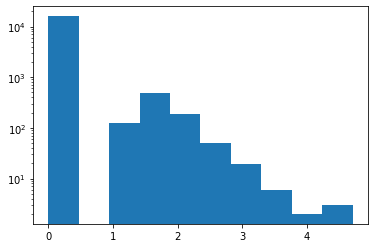

In [30]:
plt.hist(np.array(EBT_counts[scprep.select.get_gene_set(EBT_counts, starts_with='PDGFRA ')]).flatten())
#plt.xscale('log')
plt.yscale('log')

In [31]:
np.sum(np.array(EBT_counts[scprep.select.get_gene_set(EBT_counts, starts_with='PDGFRA ')]) > 0)

879

In [32]:
# end_genes = ['ONECUT2', 'CDX2', 'HAND1', 'PDGFRA ']
# Pick some cells associated with high expression in each gene in TP 5, then use those to go backwards.

zs.shape

(100, 3332, 5)

In [33]:
np.unique(sample_labels, return_counts=True)

(array(['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27'],
       dtype=object), array([2381, 4165, 3278, 3665, 3332]))

In [34]:
EBT_5 = EBT_counts[sample_labels == 'Day 24-27']

In [35]:
EBT_5.shape

(3332, 17845)

In [36]:
for gene in end_genes:
    print(gene, np.sum(np.array(EBT_5[scprep.select.get_gene_set(EBT_counts, starts_with=gene)]) > 0))

PDGFRA  324
HAND1 218
SOX17 12
ONECUT2 10


In [37]:
masks = {}
top_idxs = {}
for gene in end_genes:
    top_idx = np.array(EBT_5[scprep.select.get_gene_set(EBT_counts, starts_with=gene)]).flatten().argsort()[-9:]
    top_mask = np.array(pd.Series(range(3332)).isin(top_idx))
    masks[gene] = top_mask
    top_idxs[gene] = top_idx
    print(gene, top_idx)

PDGFRA  [1896 2642  488  748  664  697 1419  300  432]
HAND1 [1959 3195  936 2133  375  668  501 2484 1476]
SOX17 [2053 2595 2664 1988 2353 1129 2823  738  532]
ONECUT2 [2920  555 2283  718 1275 2125 1838 2129 2277]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

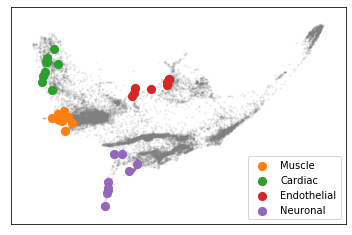

In [38]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(Y_phate, c='Gray', alpha=0.1, ax=ax)
#scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'], ax=ax)
for i, gene in enumerate(end_genes):
    scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'][masks[gene]], 
                          ax=ax, c = colors[gene], label=end_points[i], ticks=[])
    
plt.legend()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

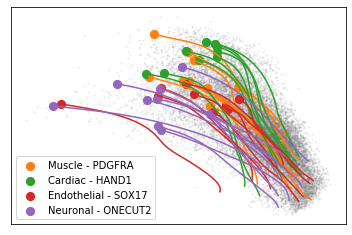

In [39]:


#import matplotlib.
dn = phate_operator.graph.data_nu

fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(dn, c='Gray', alpha=0.1, ax=ax)
#scprep.plot.scatter2d(dn[sample_labels=='Day 24-27'], ax=ax)
for i, gene in enumerate(end_genes):
    #print(colors[gene])
    scprep.plot.scatter2d(dn[sample_labels=='Day 24-27'][masks[gene]], ax=ax, 
                          label='%s - %s' % (end_points[i], end_genes[i]), c=colors[gene], ticks=[])

for gene in end_genes:
    for g in top_idxs[gene]:
        ax.plot(zss[:,g,0], zss[:,g,1], c=colors[gene])
plt.legend()

In [59]:
paths = phate_operator.transform(np.reshape(np.concatenate([zss, np.zeros((100, 3332, 95))], axis=-1), (-1, 100)))

Calculating KNN search...


/home/atong/.local/lib/python3.8/site-packages/phate/phate.py:877: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 258.86 seconds.
Calculating affinities...
Calculated affinities in 5.86 seconds.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

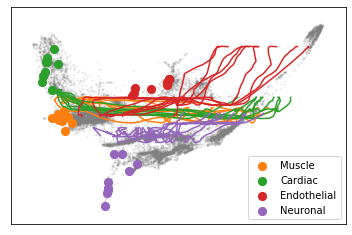

In [71]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(Y_phate, c='Gray', alpha=0.1, ax=ax)
#scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'], ax=ax)
for i, gene in enumerate(end_genes):
    scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'][masks[gene]], 
                          ax=ax, c = colors[gene], label=end_points[i], ticks=[])
    
plt.legend()

for i, gene in enumerate(end_genes) :
    pp = paths.reshape(100, -1, 2)[:, masks[gene]]
    for p in range(pp.shape[1]):
        plt.plot(pp[:, p, 0], pp[:, i, 1], c=colors[gene])

In [40]:
dims = (1,3)
#import matplotlib.
dn = phate_operator.graph.data_nu[:, dims]
dn.shape

(16821, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

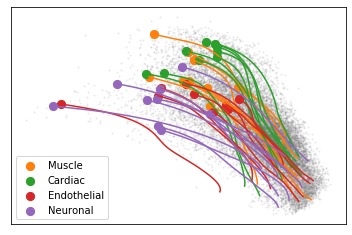

In [49]:
dims = (0,1)
#import matplotlib.
dn = phate_operator.graph.data_nu[:, dims]


fig, ax = plt.subplots(1,1)#, figsize=(20,20))
scprep.plot.scatter2d(dn, c='Gray', alpha=0.1, ax=ax)
#scprep.plot.scatter2d(dn[sample_labels=='Day 24-27'], ax=ax)
for i, gene in enumerate(end_genes):
    #print(colors[gene])
    scprep.plot.scatter2d(dn[sample_labels=='Day 24-27'][masks[gene]], ax=ax, 
                          label='%s' % (end_points[i]), c=colors[gene], ticks=[])

for gene in end_genes:
    for g in top_idxs[gene]:
        ax.plot(zss[:,g,dims[0]], zss[:,g,dims[1]], c=colors[gene])
plt.legend()

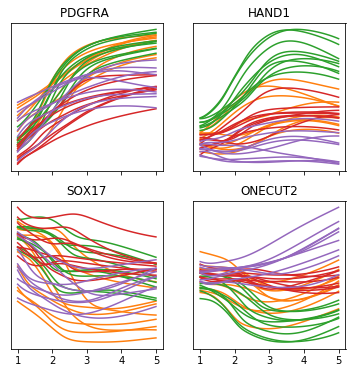

In [42]:
#fig, ax = plt.subplots(3,5, figsize=(20,12))
fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True)
ax = ax.flatten()

for i, gene in enumerate(end_genes):
    for j, eg in enumerate(end_genes):
        for g in top_idxs[eg]:
            #print(genes_of_interest_full[end_gene_indexes[i]])
            ax[i].plot(np.linspace(1,5,100)[::-1], inverse[:,g,end_gene_indexes[i]], c=colors[eg])
            ax[i].set_title(gene)
            ax[i].set_yticks([])
            ax[i].set_xticks(range(1,6))
        #ax[i].set_xticks()

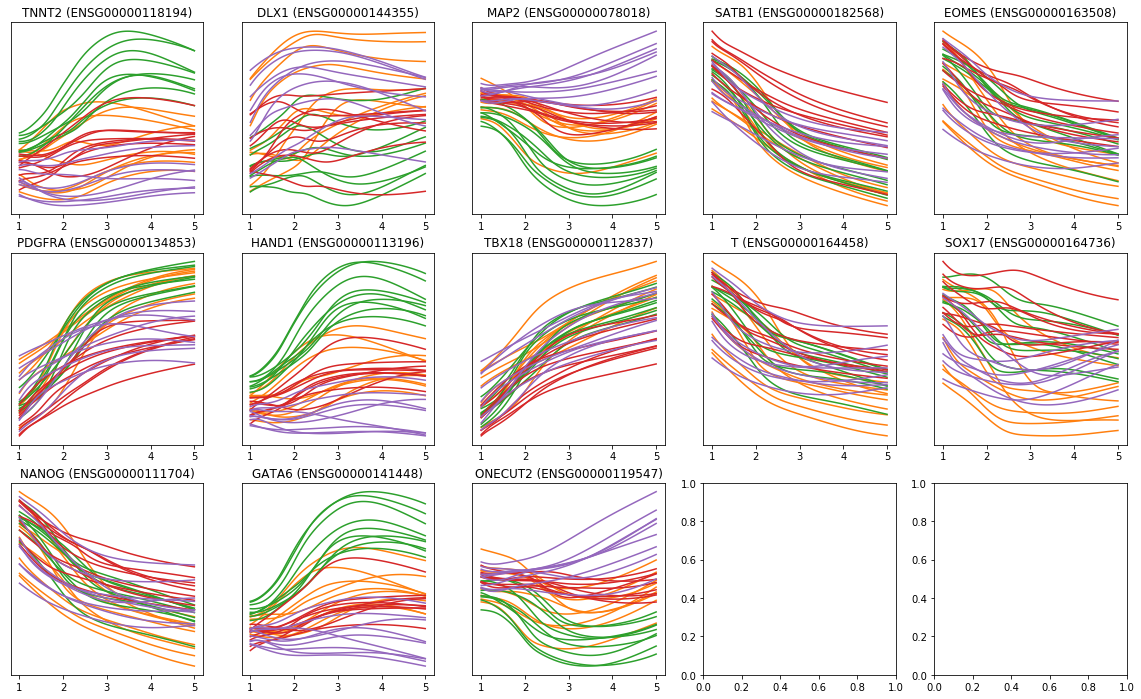

In [45]:
fig, ax = plt.subplots(3,5, figsize=(20,12))
#fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True)
ax = ax.flatten()

for i, gene in enumerate(genes):
    for eg in end_genes:
        for g in top_idxs[eg]:
            ax[i].plot(np.linspace(1,5,100)[::-1], inverse[:,g,i], c=colors[eg])
            ax[i].set_title(gene)
            ax[i].set_yticks([])
            ax[i].set_xticks(range(1,6))
        #ax[i].set_xticks()

In [44]:
print(genes)

Index(['TNNT2 (ENSG00000118194)', 'DLX1 (ENSG00000144355)',
       'MAP2 (ENSG00000078018)', 'SATB1 (ENSG00000182568)',
       'EOMES (ENSG00000163508)', 'PDGFRA (ENSG00000134853)',
       'HAND1 (ENSG00000113196)', 'TBX18 (ENSG00000112837)',
       'T (ENSG00000164458)', 'SOX17 (ENSG00000164736)',
       'NANOG (ENSG00000111704)', 'GATA6 (ENSG00000141448)',
       'ONECUT2 (ENSG00000119547)'],
      dtype='object')
